In [1]:
import numpy as np
from utils.openDSS.DSSStartup import DSSStartup
from utils.openDSS.setInfo import *
from utils.openDSS.getInfo import *
from utils.device.Inverter import Inverter
from utils.controller.AdaptiveInvController import AdaptiveInvController
from utils.controller.FixedInvController import FixedInvController

import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time
#######################################################
#######################################################
###Global variable initialization and error checking###
#######################################################
#######################################################
Sbase=1
LoadScalingFactor = 1.5
GenerationScalingFactor = 5 
SlackBusVoltage = 1.04 
NoiseMultiplyer= 0
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 42900
EndTime = 44000
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 300
PercentHacked = np.array([0,0,0,0,0, 0,0,.5,0,0,.5,.5,.5,.5,.5,0,0,.5, 0,0,0,0,0,0,0,0,0,0,0,0,0])
#PercentHacked = np.array([0,0,0,0,0, .1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VQ_start = 1.01
VQ_end = 1.03
VP_start = 1.03
VP_end = 1.05

#Set delays for each node
Delay_VBPCurveShift =   np.array([0,0,0,0,0, 60,60,60,60,60,60,60,60,60,60,60,60,60, 0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set observer voltage threshold
ThreshHold_vqvp = 0.25
power_factor=0.9
pf_converted=tan(acos(power_factor))
Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters

#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')
    
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\CIGAR\\ceds-cigar\\LBNL_Simulations\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

#######################################################
#######################################################
####         Load data from file                    ###
#######################################################
#######################################################

#Retrieving the data from the load profile
TimeResolutionOfData=10 #resolution in minute
#Get the data from the Testpvnum folder
#Provide Your Directory - move testpvnum10 from github to drive C: 
FileDirectoryBase ='C:\\CIGAR\\ceds-cigar\\LBNL_Simulations\\testpvnum10\\';
QSTS_Time = list(range(1441)) #This can be changed based on the available data - for example, 1440 timesteps
QSTS_Data = np.zeros((len(QSTS_Time),4,TotalLoads)) #4 columns as there are four columns of data available in the .mat file

for node in range(TotalLoads):
    #This is created manually according to the naming of the folder
    FileDirectoryExtension = 'node_' + str(node+1) + '_pv_' +str(TimeResolutionOfData) + '_minute.csv'
    #The total file directory
    FileName = FileDirectoryBase + FileDirectoryExtension
    #Load the file
    MatFile = np.genfromtxt(FileName, delimiter=',')    
    QSTS_Data[:,:,node] = MatFile #Putting the loads to appropriate nodes according to the loadlist
    
Generation = QSTS_Data[:,1,:]*GenerationScalingFactor #solar generation
Load = QSTS_Data[:,3,:]*LoadScalingFactor #load demand
Generation = np.squeeze(Generation)/Sbase  #To convert to per unit, it should not be multiplied by 100
Load = np.squeeze(Load)/Sbase
print('Reading Data for Pecan Street is done.')

############################################################
############################################################
#### Interpolate to change data from minutes to seconds ####
############################################################
############################################################

from scipy.interpolate import interp1d

print('Starting Interpolation...')

#interpolation for the whole period...
Time = list(range(StartTime,EndTime))
TotalTimeSteps = len(Time)
LoadSeconds = np.empty([3600*24, TotalLoads])
GenerationSeconds = np.empty([3600*24, TotalLoads])
# Interpolate to get minutes to seconds
for node in range(TotalLoads): # i is node
    t_seconds = np.linspace(1,len(Load[:,node]), int(3600*24/1))
    f = interp1d(range(len(Load[:,node])), Load[:,node], kind='cubic', fill_value="extrapolate")
    LoadSeconds[:,node] = f(t_seconds) #spline method in matlab equal to Cubic Spline -> cubic
    
    f = interp1d(range(len(Generation[:,node])), Generation[:,node], kind='cubic', fill_value="extrapolate")
    GenerationSeconds[:,node]= f(t_seconds)

# Initialization
# then we take out only the window we want...
LoadSeconds = LoadSeconds[StartTime:EndTime,:]
GenerationSeconds = GenerationSeconds[StartTime:EndTime,:]
Load = LoadSeconds
Generation = GenerationSeconds
Origin_Load = LoadSeconds
Origin_Generation = GenerationSeconds

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.
Reading Data for Pecan Street is done.
Starting Interpolation...


In [2]:
#gen = pd.read_csv('C:\\Users\\Toan Ngo\\Documents\\gen.csv', header=None)
#load = pd.read_csv('C:\\Users\\Toan Ngo\\Documents\\load.csv', header=None)

Load Interpolation has been done. No Noise was added to the load profile.
Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.


C:\Users\danie\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


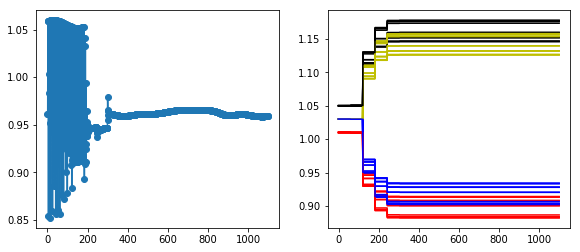

In [3]:
Load = Origin_Load.copy()
Generation = Origin_Generation.copy()


#this is for permutate the Load and Generation profile on each node
#Load = np.random.permutation(Load.T).T
#Generation = np.random.permutation(Generation.T).T

#Create noise vector
Noise = np.empty([TotalTimeSteps, TotalLoads])
for node in range(TotalLoads):
    Noise[:,node] = np.random.randn(TotalTimeSteps) 

#Add noise to loads
for node in range(TotalLoads):
    Load[:,node] = Load[:,node] + NoiseMultiplyer*Noise[:,node]

if NoiseMultiplyer > 0:
    print('Load Interpolation has been done. Noise was added to the load profile.') 
else:
    print('Load Interpolation has been done. No Noise was added to the load profile.') 

MaxGenerationPossible = np.max(Generation, axis = 0)
sbar = MaxGenerationPossible

start_time = time.time()

#########################################################
################### RESTART OPENDSS #####################
#########################################################
DSSStart = DSSStartup()
DSSText =DSSStart['dsstext']
DSSSolution = DSSStart['dsssolution']
DSSCircuit = DSSStart['dsscircuit']
DSSObj = DSSStart['dssobj']
DSSMon = DSSCircuit.Monitors
DSSText.command = 'Compile C:\\CIGAR\\ceds-cigar\\LBNL_Simulations\\feeders\\feeder34_B_NR\\feeder34_B_NR.dss'
DSSSolution.Solve()
if not DSSSolution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    DSSMon.ResetAll
    setSolutionParams(DSSObj,'daily',1,1,'off',1000000,30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=DSSCircuit.Loads.Count
    AllLoadNames=DSSCircuit.Loads.AllNames
    print('OpenDSS Model Compliation Done.')

setSourceInfo(DSSObj,['source'],'pu',[SlackBusVoltage])
############################################
############ INIT NODES ####################
############################################
nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

for i in range(len(AllLoadNames)):
    df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
    nodes[i] = df
    nodes[i].loc['Generation'] = Generation[:,i]
    nodes[i].loc['P'] = 0
    nodes[i].loc['Q'] = 0

################################################
############ INIT INVERTERS ####################
################################################
inverters = {}
features = ['Generation', 'sbar']

offset = 5
numberofInverters = Number_of_Inverters

for i in range(len(AllLoadNames)):
    inverters[i] = []
    if offset-1 < i < numberofInverters + offset:
        df = pd.DataFrame(columns=list(range(TotalTimeSteps)),index=features)
        df.loc['Generation'] = Generation[:,i]
        df.loc['sbar'] = sbar[i]
        timeList = list(range(TotalTimeSteps))
        inv = {}
        inv['device'] = Inverter(timeList,lpf_meas=1,lpf_output=0.1)
        inv['controller'] = AdaptiveInvController(timeList, VBP = np.array([1.01, 1.03, 1.03, 1.05]), 
                                                  delayTimer=Delay_VBPCurveShift[i])
        inv['info'] = df
        inverters[i].append(inv)


for timeStep in range(TotalTimeSteps): 
    ####################################################
    ################ run the simulation ################
    ####################################################
    #for the first steps, we just init voltage value, no pq injection
    if timeStep == 0:
        for node in range(len(AllLoadNames)):
            nodeName = AllLoadNames[node]
            setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node]])
            setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node]])
    else:
        for node in range(len(AllLoadNames)):
            nodeName = AllLoadNames[node]
            setLoadInfo(DSSObj, [nodeName], 'kw', [Load[timeStep, node] + nodes[node].at['P', timeStep-1]])
            setLoadInfo(DSSObj, [nodeName], 'kvar', [pf_converted*Load[timeStep, node] + nodes[node].at['Q', timeStep-1]])

    DSSSolution.Solve()
    if (not DSSSolution.Converged):
        print('Solution Not Converged at Step:', timeStep)

    #get the voltage info
    nodeInfo = getLoadInfo(DSSObj, [])
    #distribute voltage to node
    for i in range(len(nodes)):
        node = nodes[i]
        node.at['Voltage', timeStep] = nodeInfo[i]['voltagePU']
    #############################################################
    #############################################################
    #############################################################

    if timeStep == TimeStepOfHack-1:
        for node in range(len(AllLoadNames)):
            if inverters[node] != []:
                inverter = inverters[node][0]
                #create new inverter
                hackedInv = copy.deepcopy(inverter)
                for k in range(timeStep, TotalTimeSteps):
                    hackedInv['controller'] = FixedInvController(timeList, VBP = np.array([1.01, 1.015, 1.015, 1.02]))

                hackedInv['info'].loc['sbar'][timeStep:] = hackedInv['info'].loc['sbar'][timeStep:]*PercentHacked[node]
                hackedInv['info'].loc['Generation'][timeStep:] = hackedInv['info'].loc['Generation'][timeStep:]*PercentHacked[node]
                inverters[node].append(hackedInv)
                #generation and sbar change on the original inverter
                inverter['info'].loc['sbar'][timeStep:] = inverter['info'].loc['sbar'][timeStep:]*(1-PercentHacked[node])
                inverter['info'].loc['Generation'][timeStep:] = inverter['info'].loc['Generation'][timeStep:]*(1-PercentHacked[node])
    ########################################################################
    ########################################################################
    ########################################################################

    if timeStep == TotalTimeSteps-1:
        terminal = True

    for node in range(len(AllLoadNames)):
        #if we have inverters at that node then...
        if inverters[node] != []:
            invertersNode = inverters[node] #get the list of inverters at that node
            for inverter in invertersNode: #get an inverter at that node            
                #################################################
                device = inverter['device']
                controller = inverter['controller']
                info = inverter['info']

                #calcuate P Q injection by inverter
                p_inv, q_inv = device.step(v=nodes[node].at['Voltage', timeStep], 
                                                solar_irr=info.at['Generation', timeStep],
                                                solar_minval=5, 
                                                Sbar=info.at['sbar', timeStep], 
                                                VBP= controller.get_VBP())

                #add P Q injection to the node
                nodes[node].at['P', timeStep] += p_inv
                nodes[node].at['Q', timeStep] += q_inv

                #change internal VBP 
                controller.act(nk=0.1, device=device, thresh=0.25)

######### drawing #####################
f = plt.figure()
f.set_figheight(4)
f.set_figwidth(20)
f.add_subplot(1,4,1)
plt.plot(nodes[7].loc['Voltage'], marker='o')

for i in range(5,18):
    x = inverters[i][0]['controller'].VBP
    y=np.zeros([len(x),x[0].shape[0]])
    for i in range(len(x)):
        y[i,:] = x[i]
    f.add_subplot(1,4,2)
    plt.plot(y[:,0], 'r')
    plt.plot(y[:,1], 'y')
    plt.plot(y[:,2], 'b')
    plt.plot(y[:,3], 'k')
